In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# the following line is used to allow plotting inside the .ipynb file
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (15, 6)  # overwrite the default figure size
plt.rcParams['axes.grid'] = True          # add the grid lines by default   

We start by loading the data from the CSV file.

In [3]:
site1 = pd.read_csv("../../data/week2/windspeed.csv", parse_dates=['Newdate'])
site1.head()

,DateTime,WindSpeed,U,V,RH,P,T,WS,WD,Newdate,Year,Month,Day,Hour
0,01/01/2011 01:00,10.14,3.373566,-5.185395,0.005022,102321.7031,277.546997,6.186216,326.952,2011-01-01,2011,1,1,1
1,01/01/2011 02:00,10.12,1.926434,-5.926662,0.004975,102365.1875,277.406067,6.231892,341.993,2011-01-01,2011,1,1,2
2,01/01/2011 03:00,8.94,0.625309,-6.506193,0.004870,102432.4219,277.108398,6.536173,354.510,2011-01-01,2011,1,1,3
3,01/01/2011 04:00,9.53,-0.294136,-6.760742,0.004642,102493.9609,276.832886,6.767137,2.491,2011-01-01,2011,1,1,4
4,01/01/2011 05:00,11.68,-0.551288,-6.811029,0.004435,102540.0000,276.397736,6.833304,4.627,2011-01-01,2011,1,1,5


We will only windspeed data for the year 2013 and calculate daily averages, using Newdate as the time index.

In [4]:
site1 = site1.set_index('Newdate')                         # setting Newdate as the index
site1 = site1.loc['2013':'2014', 'WindSpeed']              # taking only Windspeed for the year 2013

# averaging data to daily
mean_without_skipping_na = lambda x: x.mean(skipna=False)  # by default pandas would skipna
mean_speed = site1.groupby(pd.Grouper(freq='D')).apply(mean_without_skipping_na)

We can now plot the data

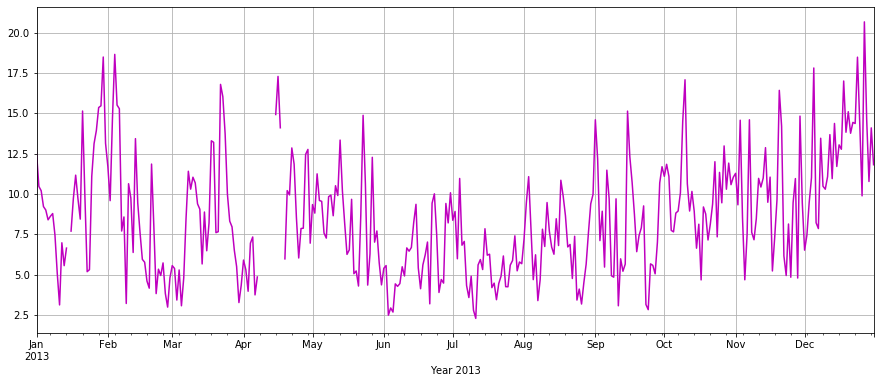

In [5]:
ax = mean_speed.plot(y='WindSpeed', c='m')
ax.set_xlabel("Year 2013");

To visualise the some statistics about the missing data we can create a couple of auxiliary functions, and then calling them

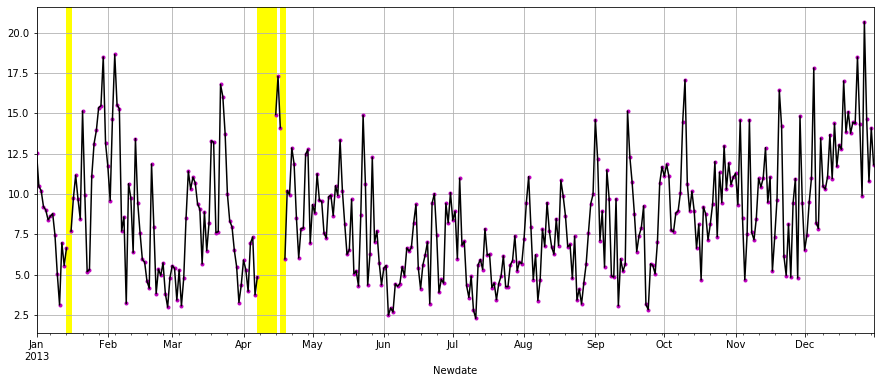

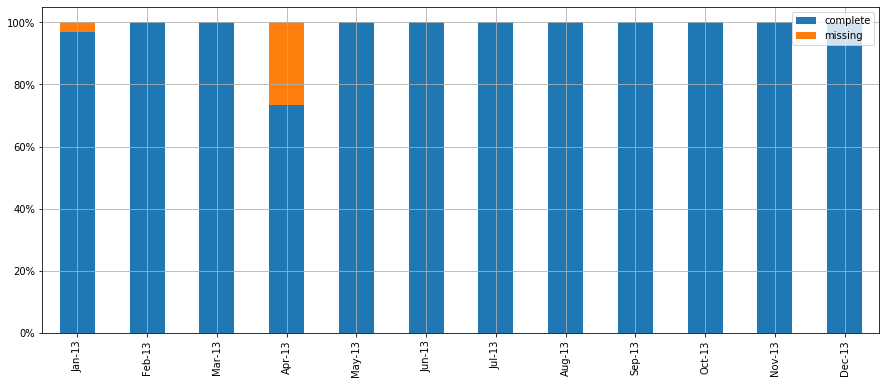

In [6]:
def highlight_missing_timeseries_data(timeseries):
    ax = timeseries.plot(style='.m')
    ax = timeseries.plot(style='-k', ax=ax)

    is_nan = pd.isnull(timeseries)
    is_area_range = (is_nan.shift(1) | is_nan.shift(-1)) & ~is_nan
    area_edges = timeseries.index[is_area_range]
    for area_start, area_end in zip(area_edges[::2], area_edges[1::2]):
        ax.axvspan(area_start, area_end, color='yellow')
        
    return ax
        
def plot_monthly_missing_data_percentage(timeseries):
    perc_complete = mean_speed.notnull().groupby(pd.Grouper(freq='M')).mean()

    ax = pd.DataFrame({
        'complete': perc_complete.values, 
        'missing': 1-perc_complete.values
    }, index=perc_complete.index.strftime('%b-%y')).plot.bar(stacked=True)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    
    return ax

highlight_missing_timeseries_data(mean_speed)

plot_monthly_missing_data_percentage(mean_speed)

### Imputing 

To impute the missing data we can either use the `fillna` or `interpolate` function of pandas.

The `fillna` can be used to set a fixed value such as a mean or median.

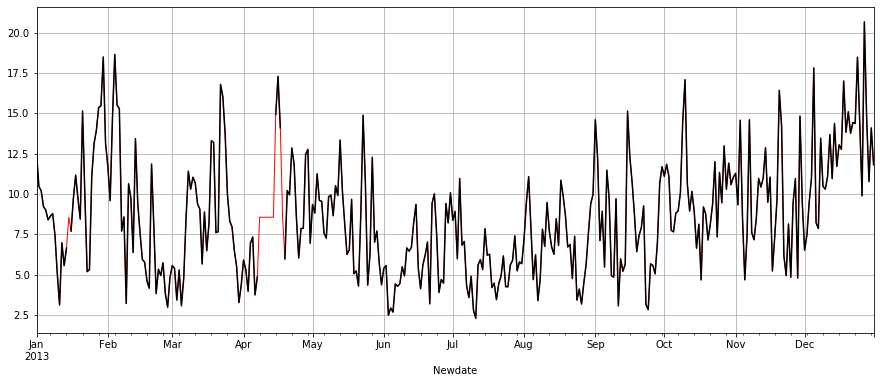

In [7]:
rolling_avg = mean_speed.mean()                        # calculating the mean

ax = mean_speed.fillna(rolling_avg).plot(c='r', lw=1)  # using it to fill the nan
mean_speed.plot(style='k', ax=ax)                      # add in black the raw values as reference

We can also impute values, based on a time series model using `interpolate` (see [docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html)).

This usually gives more realistic results, but is highly dependent on whether the time series model is suitable or not.

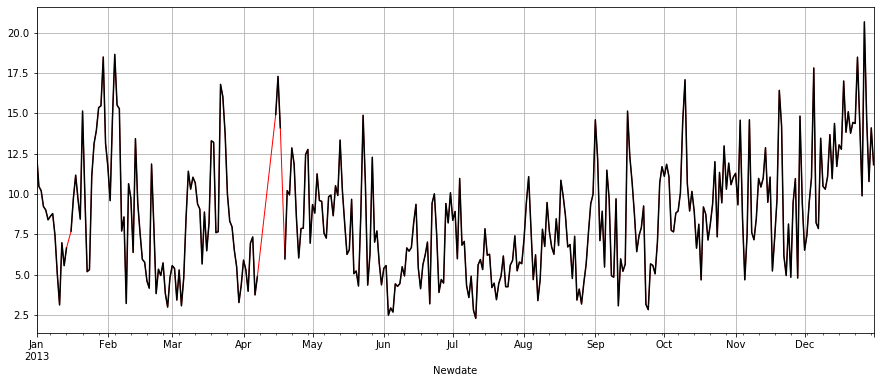

In [8]:
ax = mean_speed.interpolate(method='linear').plot(c='r', lw=1)  # imputing using the linear interpolation
mean_speed.plot(style='k', ax=ax)                               # add in black the raw values as reference

In this particular example, there is actually a much easier solution. The missing values for the daily time series is only due to there being missing values for a small number of hours for each day. So far we have made the daily mean a missing value (NA) as soon as the hourly measurements were missing for a single hour.

Instead, we could simply calculate the daily average from the other hours of the day, so that we would only get missing values if we had no measurements at all for that day.

This is the normal behaviour of pandas's `mean` function.

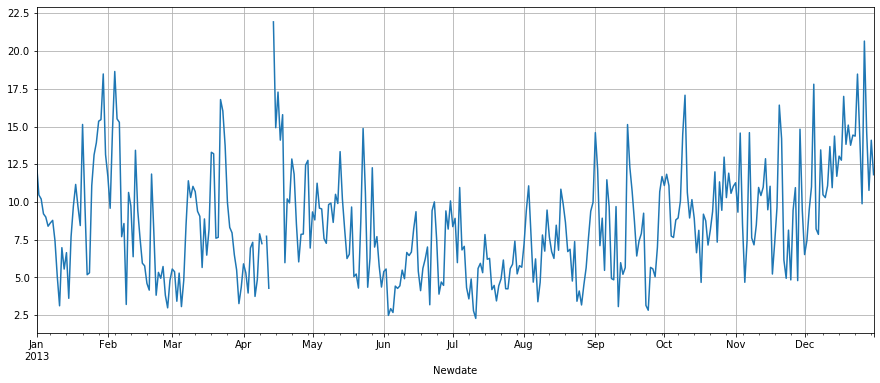

In [9]:
mean_speed = site1\
    .groupby(pd.Grouper(freq='D'))\
    .mean()

mean_speed.plot()

This dataset now contains only a couple of missing days of data, which we can fill with a linear interpolation.

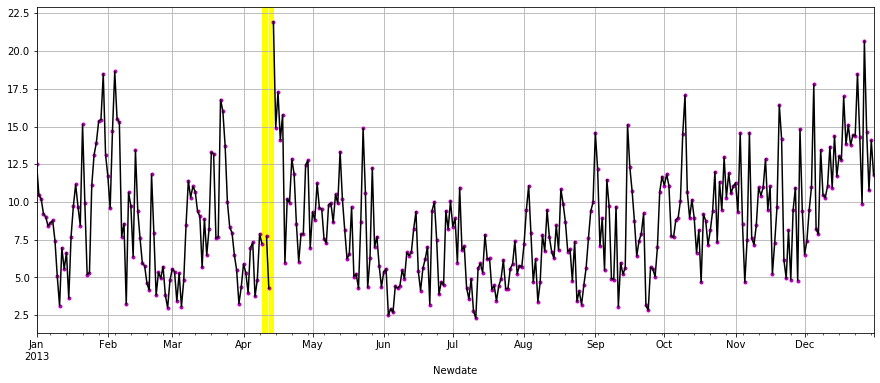

In [11]:
highlight_missing_timeseries_data(mean_speed)

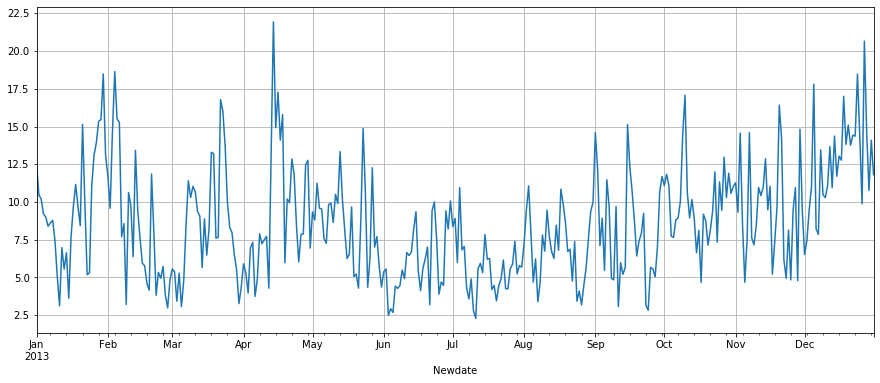

In [12]:
mean_speed.interpolate(method='linear').plot()